In [57]:
""" 
SOAR Offline Laptime Optimization for Reference Trajectory Generation
AA 203/273 Spring 2024
Andrew Wang, Bryan Yang
"""
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
from agents import BicycleVehicle
from config import *

In [2]:
%load_ext autoreload
%autoreload 2

In [126]:
# Set up track for optimization
veh_config = get_vehicle_config()
scene_config = get_scene_config(track_type=OVAL_TRACK)
veh_constraints = get_vehicle_opt_constraints(veh_config, scene_config)
track = scene_config["track"]

Track Closure Error [-1.33339491e-02 -4.81617196e-02  8.30401052e-08]


In [127]:
print(track.name)

OVAL w/Straight 100, Curve Radius 90


In [140]:
def compute_raceline(track, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config["lf"]
    lr = vehicle_config["lr"]

    mass = vehicle_config["m"]
    Iz = vehicle_config["Iz"]

#     tire_model = vehicle_config.tire_model

#     mu = vehicle_config.wheel_friction
#     Br = vehicle_config.pacejka_b_rear
#     Bf = vehicle_config.pacejka_b_front
#     Cr = vehicle_config.pacejka_c_rear
#     Cf = vehicle_config.pacejka_c_front
#     Dr = vehicle_config.pacejka_d_rear
#     Df = vehicle_config.pacejka_d_front

#     xu_ub = vehicle_constraints['xu_ub']
#     xu_lb = vehicle_constraints['xu_lb']
#     du_ub = vehicle_constraints['du_ub']
#     du_lb = vehicle_constraints['du_lb']
    c_alpha_f = vehicle_config["c"]
    c_alpha_r = vehicle_config["c"]
    
    Cd = veh_config["Cd"]
    SA = veh_config["SA"]
    
    v_long_max = vehicle_constraints["ub_vx"]
    v_long_min = vehicle_constraints["lb_vx"]
    v_tran_max = vehicle_constraints["ub_vy"]
    v_tran_min = vehicle_constraints["lb_vy"]
    psidot_max = vehicle_constraints["ub_omega"]
    psidot_min = vehicle_constraints["lb_omega"]
    e_psi_max = vehicle_constraints["ub_epsi"]
    e_psi_min = vehicle_constraints["lb_epsi"]
    e_y_max = vehicle_constraints["ub_ey"]
    e_y_min = vehicle_constraints["lb_ey"]
    steer_max = vehicle_constraints["ub_delta"]
    steer_min = vehicle_constraints["lb_delta"]

    a_max = vehicle_config["max_accel"]
    a_min = -vehicle_config["max_accel"]
    steer_rate_max = vehicle_config["max_steer_rate"]
    steer_rate_min = -vehicle_config["max_steer_rate"]

#     a_rate_max = du_ub.u_a
#     a_rate_min = du_lb.u_a


    print('=================== Raceline computation ===================')
    print('Track name: %s' % track.name)
    print('     - length: %g m' % track.total_len)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - Drag Coefficient: %g' % Cd)
    print('     - frontal area: %g m^2' % SA)
#     print('     - tire model: %s' % tire_model)
#     print('     - tire friction coefficient: %g' % mu)
#     print('     - Front tires:')
#     print('         - B: %g' % Bf)
#     print('         - C: %g' % Cf)
#     print('         - D: %g' % Df)
#     print('     - Rear tires:')
#     print('         - B: %g' % Br)
#     print('         - C: %g' % Cr)
#     print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.total_len)
    m.s = ContinuousSet(bounds=(0, m.sf))                             #s

    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
#     m.u1 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=15) #vx
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=0)    #vy
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)    #omega
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max))                    #epsi
    m.x4 = Var(m.s, bounds=(0, 200), initialize=0)                  #t
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=0)          #ey
    m.x6 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)      #delta

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.dx6ds = DerivativeVar(m.x6, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
    m.obj = Objective(expr=m.x4[m.sf], sense=minimize) # + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    # ways to tune the cost:
        # penalize u1
        # penalize u2
        # penalize u1 and u2
        # vary the penalizations on u1 and u2
        # penalize the input rate
    # to do: write this optimization problem as a function that gets called
    # different arguments will choose a different objective tuning
    # function output should be the DF, then we can store them all

    #sideslip and lateral force
    def _alphafc(m, s):
#         return m.alpha_f[s] == m.u[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
        # alpha = delta - atan((vy+lf*w)/vx)
        return m.alpha_f[s] == m.x6[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        # alpha = - atan((vy-lr*w)/vx)
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)

#     if tire_model == 'linear':
#         def _Fyfc(m, s):
#             return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
#         m.c2 = Constraint(m.s, rule=_Fyfc)
#         def _Fyrc(m, s):
#             return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
#         m.c1 = Constraint(m.s, rule=_Fyrc)
#     elif tire_model == 'pacejka':
#         def _Fyfc(m, s):
#             return m.Fyf[s] ==  Df * sin(Cf * atan(Bf * m.alpha_f[s]))
#         m.c2 = Constraint(m.s, rule=_Fyfc)
#         def _Fyrc(m, s):
#             return m.Fyr[s] ==  Dr * sin(Cr * atan(Br * m.alpha_r[s]))
#         m.c1 = Constraint(m.s, rule=_Fyrc)
        
    def _Fyfc(m, s):
#         return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        return m.Fyf[s] ==  c_alpha_f * m.alpha_f[s]
    m.c2 = Constraint(m.s, rule=_Fyfc)
    def _Fyrc(m, s):
#         return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        return m.Fyr[s] ==  c_alpha_r * m.alpha_r[s]
    m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.getCurvature(s)
        # print(cur)
        # dvx/ds = vxdot/sdot = (a - (Fd/m + Fyfsin(delta)/m + omega*vy)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
#         return m.dx0ds[s] == m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) - (0.5*Cd*SA*m.x0[s]**2/mass) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
        return m.dx0ds[s] == m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.getCurvature(s)
        # dvy/ds = vydot/sdot = 1/m*(Fyfcos(delta)+Fyr) + omega*vx)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s]*cos(m.x6[s]) + m.Fyr[s]) - m.x2[s]*m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = wdot/sdot = 1/Iz*(lf*Fyfcos(delta) - lrFyr)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.x6[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = epsidot/sdot = (omega - kappa*sdot)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.getCurvature(s)
        # dt/ds = 1/sdot = (1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.getCurvature(s)
        # dey/ds = eydot/sdot = (vxsin(epsi) + vycos(epsi))*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)
    
    def _x6dot(m, s):
        cur = track.getCurvature(s)
        # ddelta/ds = deltadot/sdot = (ddelta)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx5ds[s] == (m.u1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x6dot = Constraint(m.s, rule=_x6dot)

#     # rate constraints on acceleration
#     def _u0dotmax(m, s):
#         cur = track.getCurvature(s)
#         return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotub = Constraint(m.s, rule=_u0dotmax)
#     def _u0dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

#     rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
#         yield m.x0[0] == m.x0[track.total_len] #vx
        yield m.x1[0] == m.x1[track.total_len] #vy
        yield m.x2[0] == m.x2[track.total_len] #w
#         yield m.x3[0] == m.x3[track.total_len] #epsi
        yield m.x4[0] == 0 #t
#         yield m.x5[0] == m.x5[track.total_len] #ey
#         yield m.x6[0] == m.x6[track.total_len] #delta
        yield m.x0[0] == 0 #vx
        yield m.x1[0] == 0 #vy
        yield m.x2[0] == 0 #w
        yield m.x3[0] == 0 #epsi
        yield m.x4[0] == 0 #t
        yield m.x5[0] == 0 #ey
        yield m.x6[0] == 0 #delta
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    TransformationFactory('dae.collocation').apply_to(m, nfe=100, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 8000
    print("new")
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'delta' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]
        
        vx = value(m.x0[s])
        vy = value(m.x1[s])
        w = value(m.x2[s])
        epsi = value(m.x3[s])
        t = value(m.x4[s])
        ey = value(m.x5[s])
        delta = value(m.x6[s])
        a = value(m.u0[s])
        ddelta = value(m.u1[s])
        
        cl_state = np.array([s, ey, epsi, vx, vy, w, delta])
        global_state = track.CLtoGlobal(cl_state)
        x, y, theta, vx_g, vy_g, w_g, delta = global_state

        raceline['t'][j] = t
        raceline['v_long'][j] = vx
        raceline['v_tran'][j] = vy
        raceline['psidot'][j] = w
        raceline['s'][j] = s
        raceline['e_y'][j] = ey
        raceline['e_psi'][j] = epsi
        raceline['delta'][j] = delta
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = theta
        raceline['u_a'][j] = a
        raceline['u_s'][j] = ddelta

    return raceline



In [141]:
raceline = compute_raceline(track, veh_config, veh_constraints)

=================== Raceline computation ===================
Track name: OVAL w/Straight 100, Curve Radius 90
     - length: 765.487 m
     - width: 20 m
Vehicle configuration:
     - center of mass to front axle: 0.125 m
     - center of mass to rear axle: 0.125 m
     - mass: 2 kg
     - yaw inertia: 0.03 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
Vehicle input constraints:
     - max acceleration: 15 m/s^2
     - min acceleration: -15 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 60 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 10 m/s
     - min lateral velocity: -10 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
new
Ipopt 3.13.4: max_iter=8000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open s

  65  4.8920027e+01 4.55e-01 5.73e+09  -1.7 3.87e-04  13.2 1.00e+00 1.00e+00h  1
  66  4.8920027e+01 4.54e-01 5.84e+09  -1.7 1.19e-03  12.7 1.00e+00 1.00e+00H  1
  67r 4.8920027e+01 4.54e-01 1.00e+03  -0.3 0.00e+00  12.2 0.00e+00 4.77e-07R 22
  68r 4.8912404e+01 9.33e-02 1.49e+03  -0.3 5.64e+02    -  6.40e-03 1.29e-03f  1
  69  4.8912404e+01 9.33e-02 1.04e+03  -1.7 7.78e+05    -  2.42e-01 3.02e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.8916109e+01 4.08e+03 1.58e+03  -1.7 1.03e+06    -  3.82e-01 6.19e-02h  5
  71  4.8916213e+01 4.07e+03 1.95e+03  -1.7 5.78e+05    -  4.61e-01 7.73e-03h  8
  72  4.8916202e+01 4.06e+03 2.20e+03  -1.7 5.05e+05    -  8.05e-01 7.73e-03h  8
  73  4.8911572e+01 4.06e+03 2.18e+03  -1.7 4.97e+05    -  8.91e-01 1.55e-02h  7
  74r 4.8911572e+01 4.06e+03 1.00e+03   3.6 0.00e+00    -  0.00e+00 2.87e-07R 14
  75r 4.8954058e+01 6.22e+02 4.27e+07   3.6 4.06e+06    -  5.50e-02 9.90e-04f  1
  76  4.8958690e+01 2.57e+04

 155  2.2460982e+01 8.53e-01 9.60e+01  -2.5 7.53e+00  -4.1 6.92e-01 1.00e+00h  1
 156  2.2350087e+01 6.42e-01 2.07e+02  -2.5 1.16e+01  -4.5 1.00e+00 3.10e-01h  1
 157  2.2351617e+01 9.40e-03 5.99e+01  -2.5 2.96e+00  -4.1 3.32e-01 1.00e+00h  1
 158  2.2230354e+01 3.49e+05 8.60e+12  -2.5 8.90e+05  -4.6 1.00e+00 4.99e-01h  2
 159  2.2123048e+01 9.33e+02 8.11e+18  -2.5 1.77e+06  -4.2 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r 2.2123048e+01 9.33e+02 1.00e+03   3.0 0.00e+00  19.7 0.00e+00 0.00e+00R  1
 161r 2.2149675e+01 9.65e+01 3.92e+09   3.0 9.33e+05    -  4.56e-02 9.90e-04f  1
 162  2.2149701e+01 3.94e+05 1.85e+05  -2.5 4.19e+09    -  8.41e-01 4.87e-04h 12
 163  2.2151267e+01 3.88e+05 7.59e+03  -2.5 3.04e+05    -  9.60e-01 1.56e-02h  7
 164  2.2151775e+01 3.87e+05 8.70e+03  -2.5 1.72e+06    -  1.06e-01 2.91e-03h  7
 165  2.2151940e+01 3.86e+05 3.06e+02  -2.5 1.51e+06    -  9.93e-01 9.74e-04h 11
 166  2.2151881e+01 3.86e+05

 244  2.3855340e+01 5.84e-02 3.86e+03  -2.5 3.16e+06    -  9.73e-01 6.10e-05h 15
 245  2.3855221e+01 7.92e-02 7.02e+02  -2.5 2.37e+05    -  9.62e-01 4.88e-04h 12
 246  2.3855087e+01 8.44e-02 1.43e+03  -2.5 9.58e+05    -  1.00e+00 5.95e-05h 14
 247  2.3854803e+01 8.88e-02 1.23e+03  -2.5 7.96e+05    -  4.15e-01 7.98e-05h 14
 248  2.3854731e+01 8.92e-02 1.04e+03  -2.5 8.16e+05    -  1.00e+00 2.09e-05h 16
 249  2.1273665e+01 3.27e+05 1.65e+02  -2.5 8.42e+05    -  4.87e-01 8.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  2.1370863e+01 2.38e+05 2.04e+05  -2.5 1.12e+03  -4.0 3.13e-02 3.52e-01h  1
 251  2.1768805e+01 1.16e+05 1.34e+04  -2.5 7.91e+02  -4.5 5.06e-01 8.65e-01h  1
 252  2.1694299e+01 6.03e+04 3.11e+04  -2.5 1.72e+02  -5.0 6.59e-01 7.10e-01h  1
 253  2.1604935e+01 2.03e+04 2.53e+04  -2.5 5.25e+01  -4.5 8.88e-01 1.00e+00h  1
 254  2.1534336e+01 1.42e+04 3.19e+10  -2.5 7.49e+04  -5.0 1.30e-01 3.49e-01H  1
 255  2.1511262e+01 1.39e+03

 334  2.1247371e+01 6.83e-01 5.33e+10  -2.5 1.35e-02  12.6 1.00e+00 1.00e+00h  1
 335  2.1247371e+01 1.50e+00 2.33e+10  -2.5 1.78e-02  12.1 4.42e-01 1.00e+00h  1
 336  2.1247371e+01 1.28e+00 2.54e+09  -2.5 4.87e-03  11.6 1.00e+00 1.00e+00h  1
 337  2.1247371e+01 5.67e-01 3.91e+09  -2.5 2.60e-02  11.2 2.26e-01 1.00e+00h  1
 338  2.1247371e+01 2.82e-01 3.01e+08  -2.5 5.63e-03  10.7 1.00e+00 1.00e+00h  1
 339  2.1247371e+01 4.69e-02 3.57e+08  -2.5 3.47e-03  10.2 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  2.1247371e+01 1.35e-01 1.06e+08  -2.5 7.10e-03   9.7 5.71e-01 5.71e-01s 22
 341  2.1247371e+01 1.35e-01 1.06e+08  -2.5 1.76e-02   9.3 9.51e-04 9.51e-04s 22
 342r 2.1247371e+01 1.35e-01 1.00e+03  -0.9 0.00e+00   8.8 0.00e+00 0.00e+00R  1
 343r 2.1248680e+01 3.11e-02 5.60e+03  -0.9 1.35e+02    -  9.30e-02 9.90e-04f  1
 344r 2.1353251e+01 7.32e-02 4.59e+04  -0.9 1.95e+00    -  9.97e-01 9.51e-02f  1
 345r 2.1463503e+01 5.99e-02

 425  1.6781374e+01 4.46e+02 9.09e+05  -5.7 9.17e+01  -2.5 4.70e-01 1.51e-01h  1
 426  1.6782893e+01 4.38e+02 3.49e+12  -5.7 2.11e+05  -3.0 9.30e-03 1.15e-02h  1
 427  1.6783104e+01 4.36e+02 3.48e+12  -5.7 2.39e+03  -2.5 7.65e-02 4.59e-03h  1
 428  1.6808674e+01 3.92e+02 3.13e+12  -5.7 5.95e+02  -2.1 1.30e-01 1.01e-01h  1
 429  1.6808943e+01 3.92e+02 3.15e+12  -5.7 1.39e+06  -2.6 1.26e-01 1.49e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.6831854e+01 3.56e+02 2.86e+12  -5.7 7.52e+02  -1.3 5.82e-03 9.21e-02h  1
 431  1.6845217e+01 3.39e+02 2.73e+12  -5.7 5.49e+03  -1.7 3.05e-01 4.84e-02h  1
 432  1.6859058e+01 3.18e+02 2.56e+12  -5.7 8.88e+02  -1.3 2.36e-01 6.05e-02h  1
 433  1.6859414e+01 3.19e+02 4.56e+12  -5.7 9.63e+05  -1.8 4.13e-01 1.62e-03h  8
 434  1.6859616e+01 3.18e+02 4.56e+12  -5.7 1.18e+02   0.4 2.18e-01 1.02e-03h  1
 435  1.6884081e+01 2.79e+02 3.99e+12  -5.7 7.98e+02  -0.0 4.13e-01 1.23e-01h  1
 436  1.6883974e+01 2.79e+02

 519  1.6636343e+01 1.29e+00 4.61e+01  -5.7 1.64e+05    -  1.03e-02 3.38e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.6619830e+01 1.33e+01 4.53e+01  -5.7 1.64e+05    -  2.37e-02 1.87e-02h  1
 521  1.6618082e+01 1.38e+01 4.51e+01  -5.7 1.62e+05    -  7.45e-03 4.27e-03H  1
 522  1.6617795e+01 1.39e+01 4.50e+01  -5.7 1.62e+05    -  3.45e-02 1.07e-03h  5
 523  1.6617746e+01 1.39e+01 4.50e+01  -5.7 1.62e+05    -  6.87e-02 3.68e-04h  8
 524  1.6617739e+01 1.39e+01 4.50e+01  -5.7 1.65e+05    -  1.78e-02 3.94e-04h  9
 525  1.6617735e+01 1.39e+01 4.50e+01  -5.7 1.62e+05    -  9.77e-03 5.37e-04h  5
 526  1.6617740e+01 1.39e+01 4.49e+01  -5.7 1.62e+05    -  5.16e-02 4.75e-04h  9
 527  1.6617751e+01 1.39e+01 4.43e+01  -5.7 1.65e+05    -  4.55e-02 2.52e-04h  9
 528  1.6617784e+01 1.39e+01 4.43e+01  -5.7 1.65e+05    -  9.24e-03 4.64e-04h  9
 529  1.6617806e+01 1.39e+01 4.43e+01  -5.7 1.61e+05    -  1.29e-01 3.01e-04h  9
iter    objective    inf_pr 

 611  1.6820938e+01 5.07e+03 5.87e+00  -5.7 1.58e+00  -5.7 9.13e-01 6.55e-01w  1
 612  1.6560734e+01 4.77e-01 3.80e+01  -5.7 8.47e-01  -5.2 7.73e-01 4.83e-05h 14
 613  1.6560749e+01 4.77e-01 3.80e+01  -5.7 1.53e+05    -  1.28e-02 5.37e-05h 15
 614  1.6560764e+01 4.77e-01 3.90e+01  -5.7 1.53e+05    -  2.88e-01 5.50e-05h 15
 615  1.6560771e+01 4.77e-01 3.90e+01  -5.7 1.53e+05    -  1.33e-02 2.91e-05h 16
 616  1.6560779e+01 4.77e-01 4.17e+01  -5.7 1.53e+05    -  8.33e-01 2.91e-05h 16
 617  1.6560787e+01 4.77e-01 4.17e+01  -5.7 1.62e+05    -  1.30e-02 2.88e-05h 14
 618  1.6560801e+01 4.77e-01 4.21e+01  -5.7 1.52e+05    -  1.49e-01 5.11e-05h 15
 619  1.6560809e+01 4.77e-01 4.22e+01  -5.7 1.52e+05    -  1.41e-02 2.93e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  1.6560809e+01 4.77e-01 4.22e+01  -5.7 1.25e+08    -  4.61e-07 4.35e-09h  6
 621  1.6560815e+01 4.77e-01 4.36e+01  -5.7 1.52e+05    -  5.32e-01 2.50e-05h 16
 622  1.6733997e+01 1.34e+04

 704  1.6561724e+01 4.75e-01 5.82e+01  -5.7 1.49e+05    -  1.65e-02 5.95e-05h 15
 705  1.6561741e+01 4.75e-01 5.82e+01  -5.7 1.49e+05    -  1.50e-01 6.07e-05h 15
 706  1.6561757e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.83e-02 6.07e-05h 15
 707  1.6561774e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.00e+00 6.07e-05h 15
 708  1.6561790e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.67e-02 5.96e-05h 15
 709  1.6561806e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.51e-01 6.07e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  1.6561823e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.86e-02 6.07e-05h 15
 711  1.6561839e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.00e+00 6.07e-05h 15
 712  1.6561855e+01 4.75e-01 5.82e+01  -5.7 1.48e+05    -  1.69e-02 5.96e-05h 15
 713  1.6830910e+01 3.36e+04 2.23e+00  -5.7 1.48e+05    -  1.51e-01 9.95e-01w  1
 714  1.6831380e+01 2.63e+04 1.15e+01  -5.7 5.48e+00  -6.3 3.90e-01 2.21e-01w  1
 715  1.6831524e+01 2.41e+04

 799  1.9113103e+01 6.33e-01 4.93e+02  -5.7 3.54e+05    -  5.38e-01 1.82e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.9851425e+01 2.17e+00 2.05e+02  -5.7 3.83e+03    -  5.83e-01 5.38e-01H  1
 801  2.1064863e+01 3.43e+00 6.88e+01  -5.7 9.39e+03    -  6.15e-01 1.00e+00H  1
 802  2.1005079e+01 4.35e+00 6.54e+01  -5.7 1.18e+04    -  6.44e-01 1.00e+00H  1
 803  2.0833586e+01 1.22e+00 6.60e+00  -5.7 1.10e+03    -  8.99e-01 1.00e+00h  1
 804  2.0086862e+01 3.35e-01 5.73e+00  -5.7 3.08e+01  -5.6 1.43e-01 7.26e-01h  1
 805  2.0064004e+01 6.20e-02 1.09e+01  -5.7 9.93e+00  -2.5 1.91e-03 1.00e+00h  1
 806  2.0024090e+01 1.04e-03 5.55e+00  -5.7 1.60e+00  -2.1 7.33e-01 1.00e+00h  1
 807  2.0004202e+01 8.93e-05 7.65e-02  -5.7 2.54e-01  -1.6 9.47e-01 1.00e+00h  1
 808  1.9982407e+01 9.84e-05 4.38e-03  -5.7 1.23e-01  -1.7 9.98e-01 9.76e-01h  1
 809  1.9949141e+01 3.52e-04 1.04e-02  -5.7 3.59e-01  -2.2 1.00e+00 5.69e-01f  1
iter    objective    inf_pr 

 891  1.6781417e+01 1.07e-01 5.41e+10  -5.7 2.56e+03  -5.6 2.24e-01 2.09e-02h  4
 892  1.6782626e+01 1.04e-01 5.26e+10  -5.7 2.93e+03  -5.7 4.65e-02 2.57e-02h  3
 893  1.6801801e+01 1.45e-01 2.28e+10  -5.7 1.01e+03  -5.3 6.49e-01 3.64e-01H  1
 894  1.6802405e+01 1.47e-01 2.23e+10  -5.7 3.34e+03  -5.7 8.28e-01 2.09e-02h  4
 895r 1.6802405e+01 1.47e-01 9.99e+02  -0.8 0.00e+00  -6.2 0.00e+00 2.67e-07R 18
 896r 1.6866813e+01 6.80e-02 9.70e+03  -0.8 5.58e+02    -  2.63e-05 7.41e-04f  1
 897  1.6865345e+01 6.76e-02 2.16e+02  -5.7 6.60e+04    -  3.39e-02 6.10e-03h  1
 898  1.6864956e+01 6.73e-02 1.92e+02  -5.7 6.59e+04    -  1.21e-01 4.10e-03f  4
 899  1.6864690e+01 6.70e-02 1.54e+02  -5.7 6.59e+04    -  2.25e-01 3.71e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.6862712e+01 6.46e-02 1.50e+02  -5.7 1.90e+03    -  9.30e-02 3.58e-02h  4
 901  1.6862667e+01 6.46e-02 1.17e+02  -5.7 3.24e+04    -  2.73e-01 9.10e-04h  9
 902  1.6862625e+01 6.45e-02

 991  1.7548487e+01 5.56e-05 1.88e+02  -5.7 5.99e+04    -  1.36e-01 3.43e-04h  9
 992  1.7548360e+01 6.53e-05 1.46e+02  -5.7 5.97e+04    -  2.51e-01 1.35e-04h 11
 993  1.7548304e+01 6.79e-05 1.25e+02  -5.7 5.91e+04    -  1.77e-01 6.34e-05h 13
 994  1.7547787e+01 6.77e-05 1.54e+02  -5.7 1.18e+03    -  4.27e-01 6.09e-04h 10
 995  1.7547749e+01 6.92e-05 1.06e+02  -5.7 5.96e+04    -  3.71e-01 4.78e-05h 14
 996  1.7140561e+01 3.74e-01 4.38e+01  -5.7 1.17e+03    -  4.43e-01 5.21e-01f  1
 997  1.7021807e+01 2.27e-01 2.03e+01  -5.7 9.78e+00  -6.2 1.91e-01 3.92e-01h  1
 998  1.6939057e+01 1.25e-01 1.12e+01  -5.7 6.35e+00  -5.8 4.06e-01 4.49e-01h  1
 999  1.6936906e+01 1.23e-01 1.68e+01  -5.7 1.65e+01  -6.3 4.16e-01 2.02e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.6880753e+01 5.74e-02 7.58e+00  -5.7 7.44e+00  -6.3 5.14e-01 5.32e-01h  1
1001  1.6847864e+01 1.98e-02 4.32e+00  -5.7 2.53e+00  -5.9 9.05e-01 6.55e-01h  1
1002  1.6836076e+01 1.27e-02

1084  1.6743728e+01 1.80e-01 1.05e+06  -8.6 5.20e+01  -8.3 7.26e-01 1.05e-01h  1
1085  1.6802627e+01 5.08e-02 2.91e+05  -8.6 1.95e+01  -7.9 6.65e-01 7.19e-01h  1
1086  1.6822235e+01 7.61e-03 4.27e+04  -8.6 7.32e+00  -7.5 9.37e-01 8.51e-01h  1
1087  1.6824075e+01 3.67e-03 1.97e+04  -8.6 2.19e+01  -8.0 6.10e-01 5.36e-01h  1
1088  1.6824207e+01 3.39e-03 1.81e+04  -8.6 6.58e+01  -8.4 4.41e-01 8.28e-02h  1
1089  1.6824868e+01 2.77e-03 9.85e+03  -8.6 2.47e+01  -8.0 2.86e-01 4.53e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  1.6824950e+01 2.50e-03 8.84e+03  -8.6 7.41e+01  -8.5 1.00e+00 1.03e-01h  2
1091  1.6825372e+01 1.03e-03 3.61e+03  -8.6 1.04e+01  -7.6 9.63e-01 5.90e-01h  1
1092  1.6825492e+01 6.59e-04 2.13e+03  -8.6 3.13e+01  -8.1 1.00e+00 4.08e-01h  1
1093  1.6825530e+01 6.41e-04 1.67e+03  -8.6 3.52e+01  -8.2 1.00e+00 2.18e-01h  3
1094  1.6825536e+01 6.35e-04 1.59e+03  -8.6 1.05e+02  -8.6 4.45e-01 4.35e-02h  4
1095  1.6825665e+01 2.20e-05

1168  1.6825664e+01 3.92e-03 2.28e+00  -8.6 2.10e+04    -  1.00e+00 1.25e-01h  4
1169  1.6825664e+01 3.83e-03 1.95e+00  -8.6 1.67e+04    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  1.6825665e+01 4.00e-03 1.30e+00  -8.6 1.31e+04    -  1.00e+00 2.50e-01h  3
1171  1.6825665e+01 4.04e-03 7.49e-01  -8.6 7.38e+03    -  1.00e+00 5.00e-01h  2
1172  1.6825665e+01 3.83e-04 7.49e-01  -8.6 6.63e+02    -  1.00e+00 1.00e+00h  1
1173  1.6825665e+01 1.89e-04 7.49e-01  -8.6 8.85e+01    -  1.00e+00 5.00e-01h  2
1174  1.6825665e+01 1.66e-04 7.49e-01  -8.6 7.36e+01    -  1.00e+00 1.00e+00h  1
Error in an AMPL evaluation. Run with "halt_on_ampl_error yes" to see details.
1175  1.6825665e+01 8.32e-05 1.11e+03  -8.6 1.45e+04    -  1.00e+00 5.00e-01h  2
1176  1.6825665e+01 8.56e-05 1.14e+03  -8.6 5.55e-02 -11.6 1.00e+00 1.00e+00h  1
1177  1.6825665e+01 6.48e-05 8.63e+02  -8.6 1.68e-01 -12.0 1.00e+00 1.00e+00h  1
1178  1.6825665e+01 4.03e-05 5

In [130]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

#     track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(9, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(9, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(9, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(9, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(9, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(9, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(9, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(9, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(9, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_s.set_xlabel('t')

#     vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

Lap time: 16.82566149969359


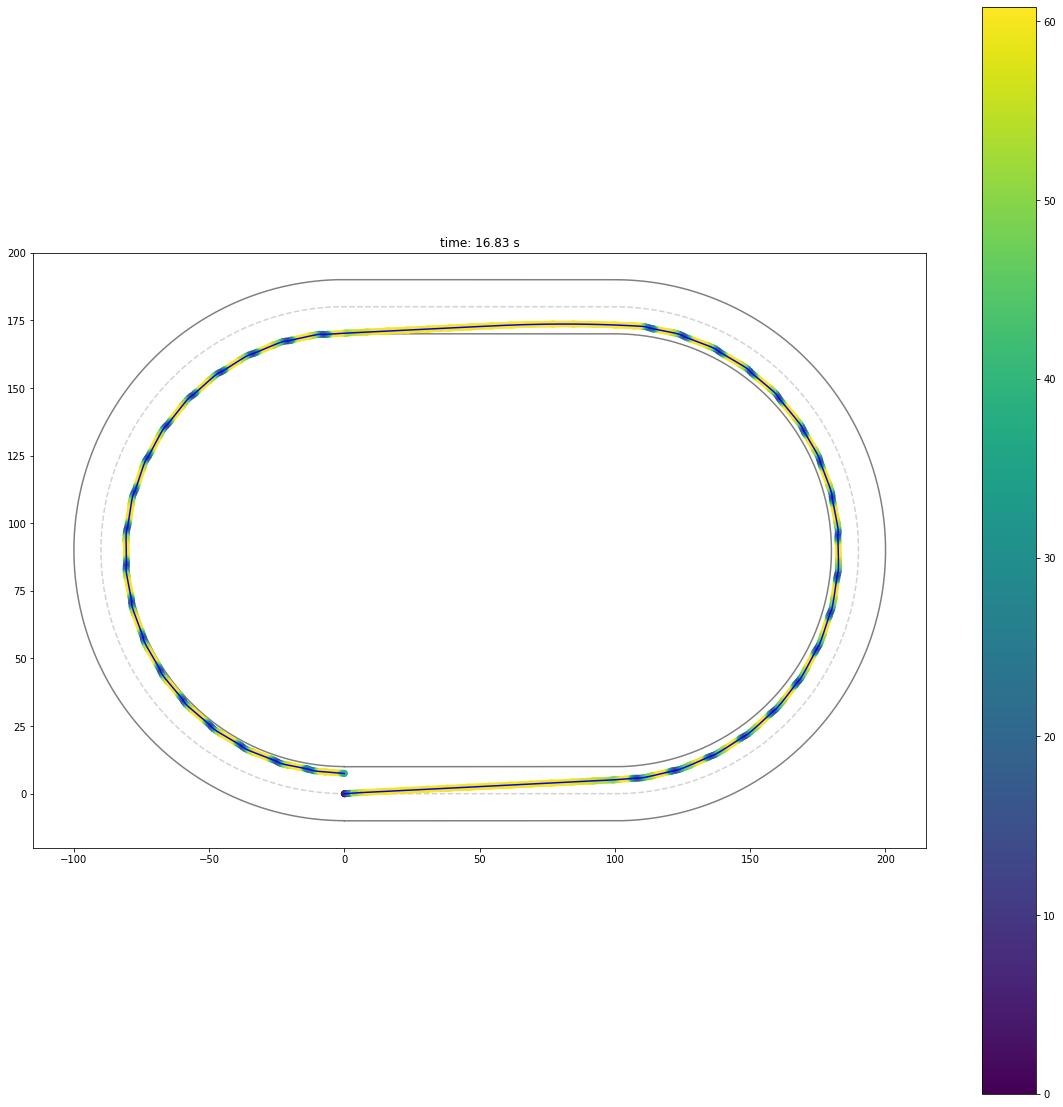

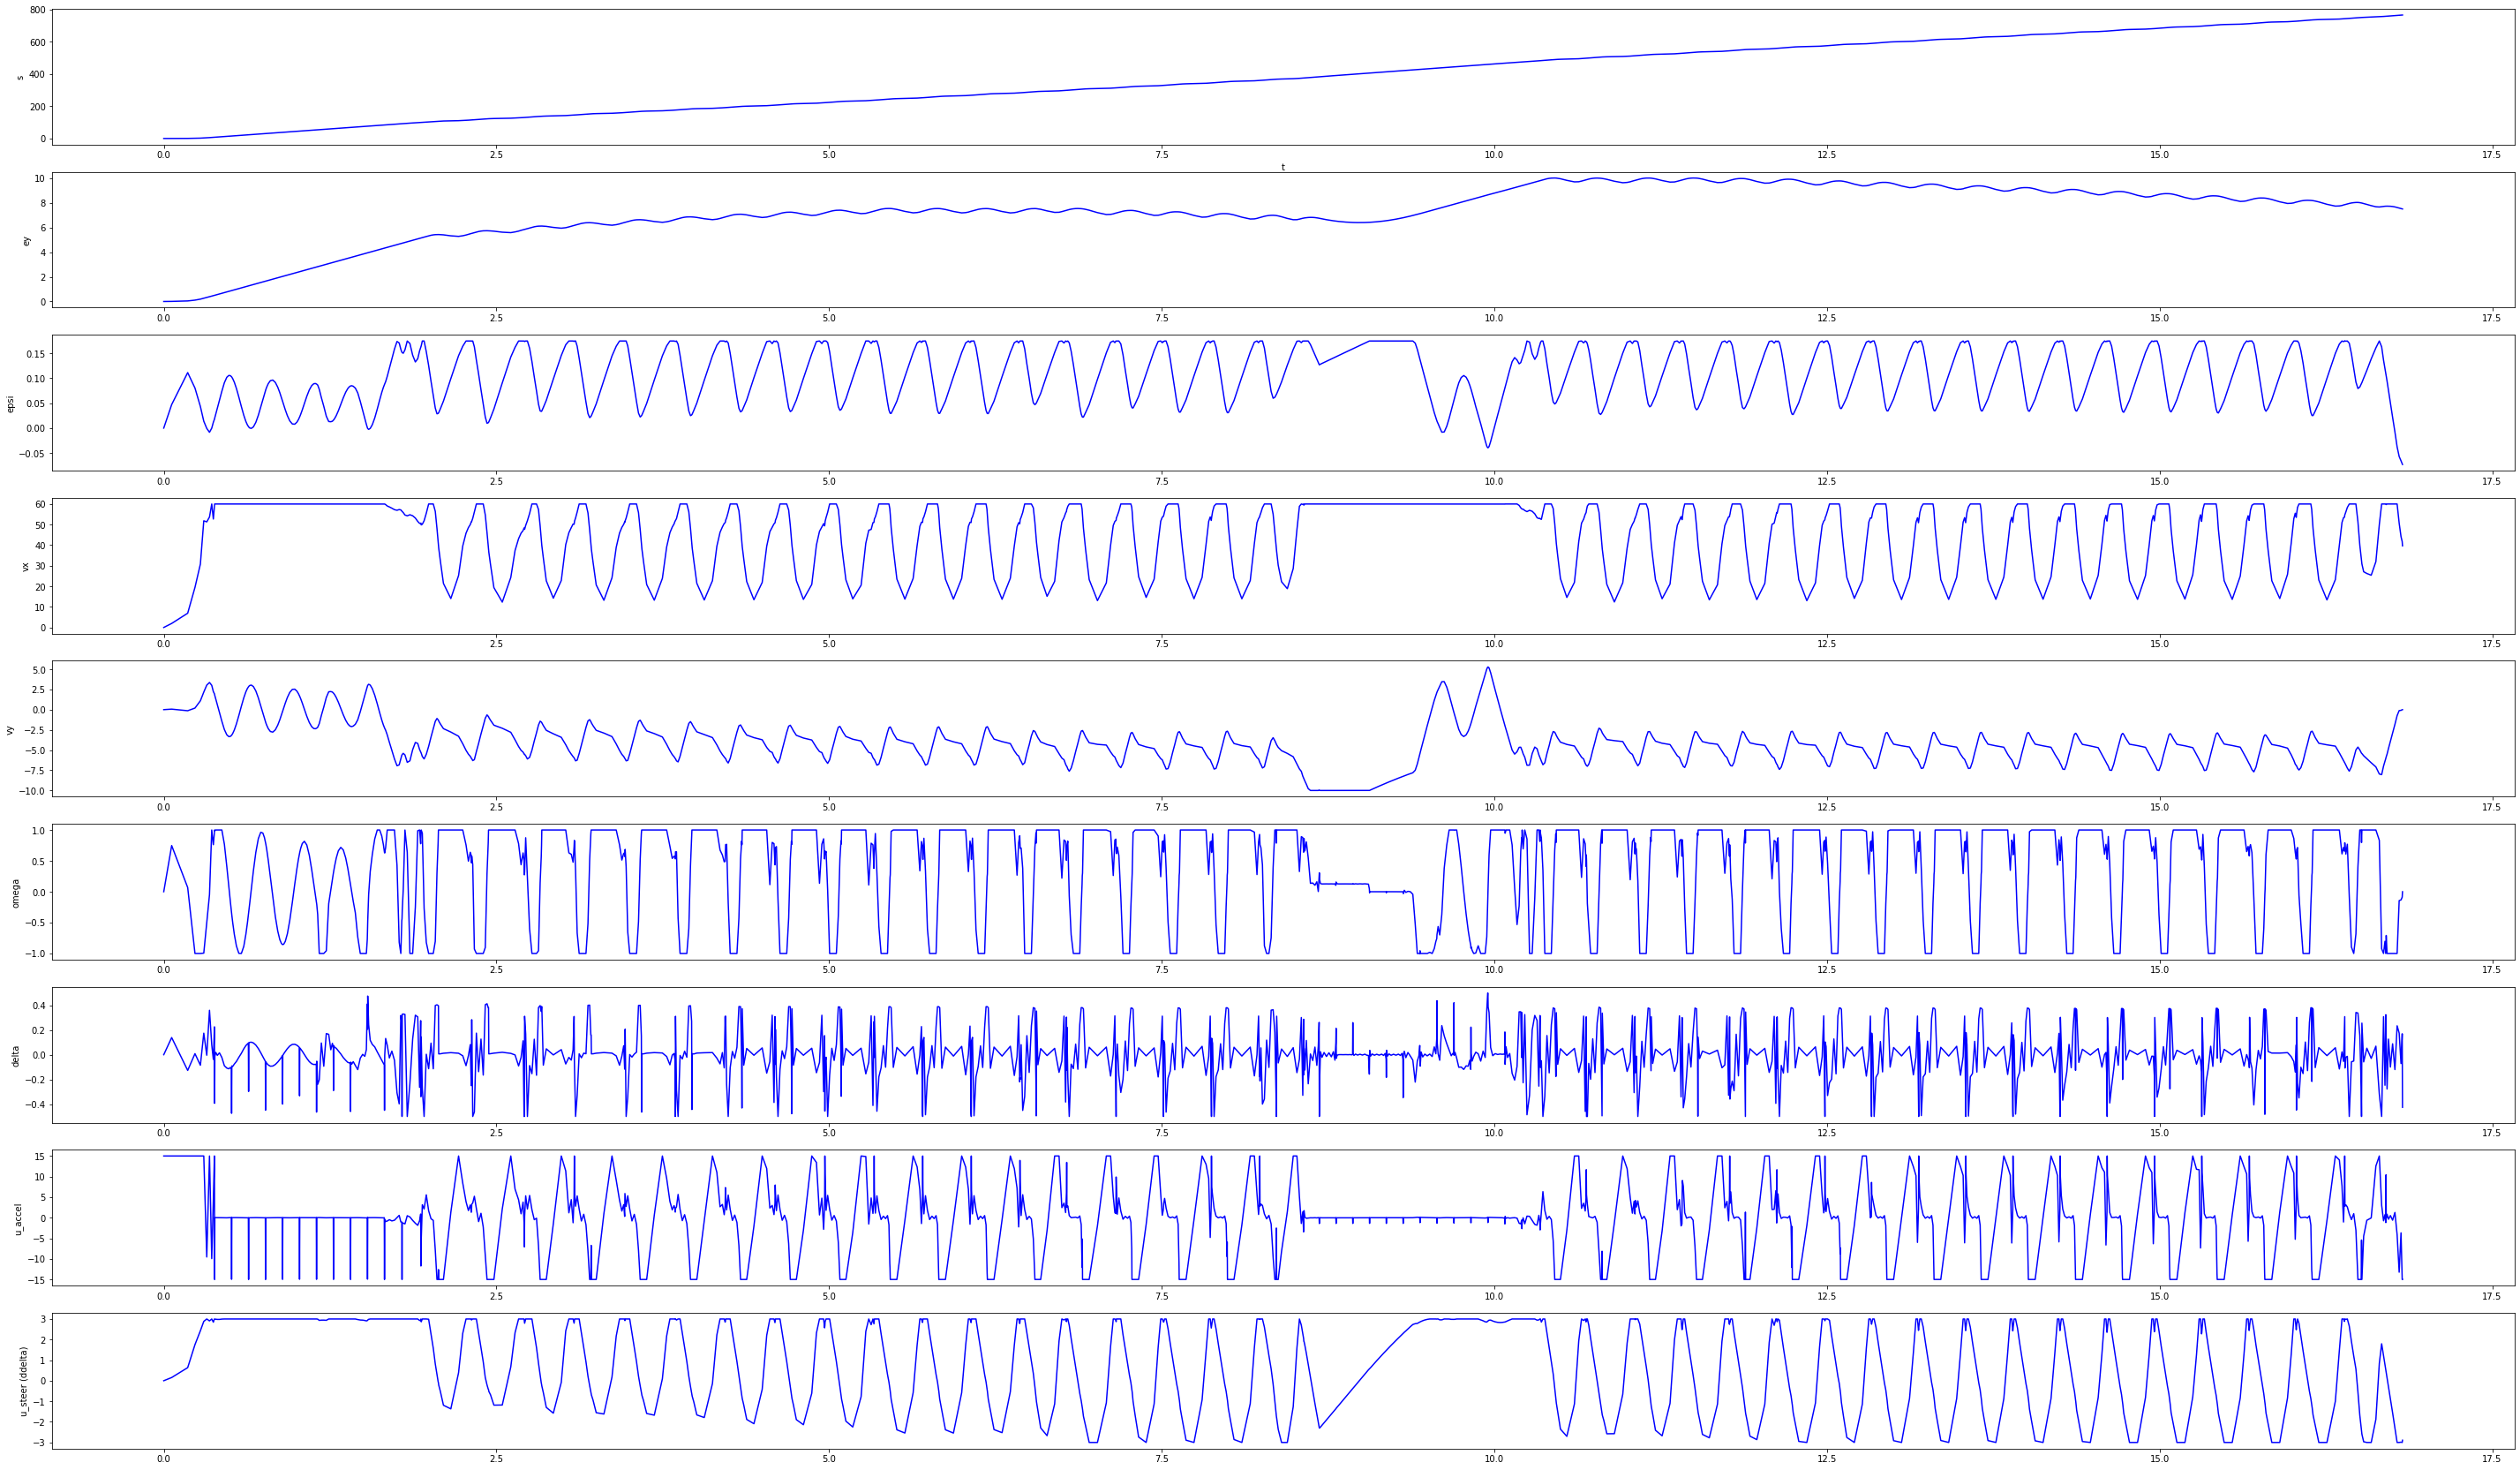

In [142]:
# Plot raceline
plot_racelines(track, raceline)

# Save raceline
filename = 'raceline.npz'
np.savez(filename, **raceline)

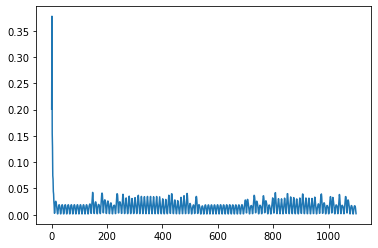

In [95]:
plt.plot(np.diff(raceline["t"]))